In [1]:
import os
import sys
import time
import argparse
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.optimizers as optimizers
from chainer import cuda
import numpy as np
import cupy
import matplotlib.pyplot as plt
from IPython import display

import models
import nn
import data_utils

In [2]:
#=============================================================================
# experimental models
#=============================================================================

class RSModel(chainer.Chain):
    """ Base model class, defines basic functionality all models
    """
    rs_num = 10 # 11 redshifts, so 10 possible predictions
    BOUND = (0.095, 1-0.095)
    def __init__(self, channels, *args, layer=models.GraphModel, theta=None):
        self.channels = channels
        last_channels = channels[:-1] + [3,]
        self.tags = ['6040', '4020', '2015', '1512', '1210', '1008', '0806', '0604', '0402', '0200']
        super(RSModel, self).__init__()        
        for i in range(len(self.tags)):
            cur_tag = self.tags[i]
            channels = self.channels if i != len(self.tags)-1 else last_channels
            self.add_link('RS_' + cur_tag, layer(channels))
        
    def fwd_pred(self, x, rs_tup=(0,10)):
        """
        # each layer receives previoous layer prediction        
        rs_tup is idx of redshift
        if rs_tup == (7, 10), then you are making prediction from redshift 0.6 to 0.0
        """
        # x.shape == (1, n_P, 6)
        rs_start, rs_target = rs_tup
        redshift_distance = rs_target - rs_start
        assert redshift_distance > 0 and rs_target <= 10
        cur_layer = getattr(self, 'RS_' + self.tags[rs_start])
        hat = cur_layer(x)
        if redshift_distance == 1:
            return hat
        else:
            for i in range(rs_start+1, rs_target):
                cur_layer = getattr(self, 'RS_' + self.tags[i])
                hat = cur_layer(hat)
            return hat
    
    def fwd_input(self, x):
        """ each layer receives external input
        """
        hat = self.RS_6040(x[0])
        error = nn.get_bounded_MSE(hat, x[1], boundary=self.BOUND)
        for i in range(1, len(self.tags)):
            cur_layer = getattr(self, 'RS_' + self.tags[i])
            hat = cur_layer(x[i])
            error *= nn.get_bounded_MSE(hat, x[i+1], boundary=self.BOUND)
        return hat, error

In [3]:
class RSModelDiff(chainer.Chain):
    """ Base model class, defines basic functionality all models
    """
    rs_num = 10 # 11 redshifts, so 10 possible predictions
    BOUND = (0.095, 1-0.095)
    def __init__(self, channels, *args, layer=models.SetModel, theta=None):
        self.channels = channels
        last_channels = channels[:-1] + [3,]
        self.tags = ['6040', '4020', '2015', '1512', '1210', '1008', '0806', '0604', '0402', '0200']
        super(RSModelDiff, self).__init__()        
        for i in range(len(self.tags)):
            cur_tag = self.tags[i]
            channels = self.channels if i != len(self.tags)-1 else last_channels
            self.add_link('RS_' + cur_tag, layer(channels))
            self.add_link('E_' + cur_tag, models.GraphModel([12,6]))
        
    def fwd_pred(self, x, rs_tup=(0,10)):
        """
        # each layer receives previoous layer prediction        
        rs_tup is idx of redshift
        if rs_tup == (7, 10), then you are making prediction from redshift 0.6 to 0.0
        """
        # x.shape == (1, n_P, 6)
        rs_start, rs_target = rs_tup
        redshift_distance = rs_target - rs_start
        assert redshift_distance > 0 and rs_target <= 10

        cur_layer = getattr(self, 'RS_' + self.tags[rs_start])
        hat = cur_layer(x)
        if redshift_distance == 1:
            return hat
        else:
            for i in range(rs_start+1, rs_target):
                cur_layer = getattr(self, 'RS_' + self.tags[i])
                hat = cur_layer(hat)
            return hat

    def fwd_input_pred_diff(self, x):
        """ each layer receives external input
        """
        hat = self.RS_6040(x[0])
        err = self.E_6040(F.concat((F.relu(hat - x[1]), F.relu(x[1] - hat)), axis=-1), add=False)
        for i in range(1, len(self.tags)):
            cur_hlayer = getattr(self, 'RS_' + self.tags[i])
            cur_elayer = getattr(self, 'E_' + self.tags[i])
            hat = cur_hlayer(err)
            if i != len(self.tags) - 1:
                err = cur_elayer(F.concat((F.relu(hat - x[i+1]), F.relu(x[i+1] - hat)), axis=-1), add=False)
        return hat, err
    
    def __call__(self, x, *args, pred_fwd=0):
        """
        x.shape == (1, n_P, 6) # just the 6.0 sample
        returns (1, n_P, 3) # the prediction on 0.0
        """
        return False

In [5]:
# static vars
#RNG_SEEDS     = [98765, 12345, 319, 77743196] # takes too long
#RNG_SEEDS     = [98765, 12345, 77743196] 
RNG_SEED = 77743196
BOUND         = 0.095
LEARNING_RATE = 0.01
GRAPH_CHANNELS = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
SET_CHANNELS   = [6, 32, 128, 256, 128, 32, 256, 16, 3]
RS_CHANNELS = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 6]
#RS_CHANNELS = [6,32,128,256,32,16,6]
#RS_CHANNELS = [6, 8, 16, 32, 16, 8, 6]
CHANNELS     = {0:SET_CHANNELS, 1:GRAPH_CHANNELS, 2:None, 3:RS_CHANNELS, 4:RS_CHANNELS}
NBODY_MODELS = {0:models.SetModel, 1:models.GraphModel, 2:models.VelocityScaled, 3:RSModel, 4:RSModelDiff}
MTAGS        = {0:'S', 1:'G', 2:'V', 3:'R', 4:'RD'}
RS_IDX = {6.0:0, 4.0:1, 2.0:2, 1.5:3, 1.2:4, 1.0:5, 0.8:6, 0.6:7, 0.4:8, 0.2:9, 0.0:10} # for new data 

In [6]:
#=============================================================================
# Training and model params
#=============================================================================
use_gpu = True
xp = cupy if use_gpu == 1 else np
num_epochs = 10
num_particles = 16
zX, zY = 6.0, 0.0
model_type = 3 # {0:set, 1:graph, 2:vel}
mtype  = NBODY_MODELS[model_type]
channels = CHANNELS[model_type]
mname  = 'RS_PG_10EPOCH_SET_'
theta = None
use_theta = 0
save_label = data_utils.get_save_label(mname, MTAGS[model_type], use_theta, num_particles, zX, zY)
if use_theta == 1:
    thetas = np.load('./thetas_timesteps.npy').item()
    theta_val = thetas[(num_particles, zX, zY)]['W']
    theta = theta_val

model_dir = './testing/'
loss_path = model_dir + 'Loss/'
if not os.path.exists(loss_path): os.makedirs(loss_path)
    
def seed_rng(s=12345):
    np.random.seed(s)
    xp.random.seed(s)
seed_rng()
print('Training {}, save: {}'.format(save_label, model_dir))

Training RS_PG_10EPOCH_SET_R_16_6000_, save: ./testing/


In [7]:
def split_data_validation(X, num_val_samples=200):
    """ split dataset into training and validation sets
    
    Args:        
        X, Y (ndarray): data arrays of shape (num_samples, num_particles, 6)
        num_val_samples (int): size of validation set
    """
    num_samples = X.shape[1]
    idx_list = np.random.permutation(num_samples)
    X = X[:,idx_list]
    X_train, X_val = X[:,:-num_val_samples], X[:,-num_val_samples:]
    return X_train, X_val

def random_augmentation_shift(batch):
    xp = chainer.cuda.get_array_module(batch)
    rands = xp.random.rand(batch.shape[-1])
    shift = xp.random.rand(batch.shape[0],3)
    
    if rands[0] < .5:            
        batch = batch[:,:,[1,0,2,4,3,5]]
    if rands[1] < .5:
        batch = batch[:,:, [0,2,1,3,5,4]]
    if rands[2] < .5:
        batch = batch[:,:, [2,1,0,5,4,3]]
    if rands[3] < .5:
        batch[:,:,0] = 1 - batch[:,:,0]
        batch[:,:,3] = -batch[:,:,3]            
    if rands[4] < .5:
        batch[:,:,1] = 1 - batch[:,:,1]
        batch[:,:,4] = -batch[:,:,4] 
    if rands[5] < .5:
        batch[:,:,2] = 1 - batch[:,:,2]
        batch[:,:,5] = -batch[:,:,5]            
    
    batchloc = batch[:,:,:3]
    batchloc += shift[:,None,:]
    gt1 = batchloc > 1
    batchloc[gt1] = batchloc[gt1] - 1
    batch[:,:,:3] = batchloc
    return batch


def next_minibatch(x_data, data_aug='shift'):
    num_rs, N, n_P, D = in_list[0].shape
    index_list = np.random.choice(N, 1)
    batch = x_data[:,index_list]
    #batches = [in_list[k][index_list] for k in range(len(in_list))]
    if data_aug == 'shift':
        return random_augmentation_shift(batch)
    else:
        return batch

In [8]:
#=============================================================================
# Load data
#=============================================================================
"""
if (zX, zY) == (0.6, 0.0) and num_particles == 32:
    X = np.load('X32_0600.npy')
    Y = np.load('Y32_0600.npy')
else:
    X, Y = data_utils.load_data(num_particles, zX, zY, normalize_data=True)

if use_gpu:
    X = cuda.to_gpu(X)
    Y = cuda.to_gpu(Y)

X_tup, Y_tup = data_utils.split_data_validation(X,Y, num_val_samples=200)
X_train, X_val = X_tup
Y_train, Y_val = Y_tup
"""
X = np.load('/home/evan/Data/nbody_simulations/ALL_16.npy') # 'ALL_32'
X = data_utils.normalize(X)
if use_gpu: X = cuda.to_gpu(X)
X_train, X_val = split_data_validation(X)
print('X_train.shape: {}'.format(X_train.shape))

X_train.shape: (11, 800, 4096, 6)


In [9]:
"""
# PROCESS USED TO CREATE FULL RS DATA
# DATA INTEGRITY WAS TESTED
DATA = data_utils.load_data(32, 6.0, 4.0, 2.0, 1.5, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0, normalize_data=True)

DATA[0].shape

data_arr = np.zeros(((len(DATA),) + DATA[0].shape)).astype(np.float32)

for i in range(len(DATA)):
    data_arr[i] = DATA[i]

np.save('/home/evan/Data/nbody_simulations/ALL_32', data_arr)
data_arr.shape
"""

"\n# PROCESS USED TO CREATE FULL RS DATA\n# DATA INTEGRITY WAS TESTED\nDATA = data_utils.load_data(32, 6.0, 4.0, 2.0, 1.5, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0, normalize_data=True)\n\nDATA[0].shape\n\ndata_arr = np.zeros(((len(DATA),) + DATA[0].shape)).astype(np.float32)\n\nfor i in range(len(DATA)):\n    data_arr[i] = DATA[i]\n\nnp.save('/home/evan/Data/nbody_simulations/ALL_32', data_arr)\ndata_arr.shape\n"

In [10]:
#=============================================================================
# Loss history
#=============================================================================
train_loss_history = np.zeros((num_epochs, X_train.shape[1])).astype(np.float32) # epoch loss hist
#num_val_batches = X_val.shape[0] // mb_size
validation_loss_history = np.zeros((X_val.shape[1])).astype(np.float32) # 200

In [11]:
#=============================================================================
# Init model and opt
#=============================================================================
model_save_label = save_label + '{}_'.format(RNG_SEED)
print('model tag: {}'.format(model_save_label))
seed_rng(RNG_SEED)
model = mtype(channels, theta=theta)
if use_gpu: model.to_gpu()
optimizer = optimizers.Adam(alpha=LEARNING_RATE)
optimizer.setup(model)

model tag: RS_PG_10EPOCH_SET_R_16_6000_77743196_


In [12]:
model

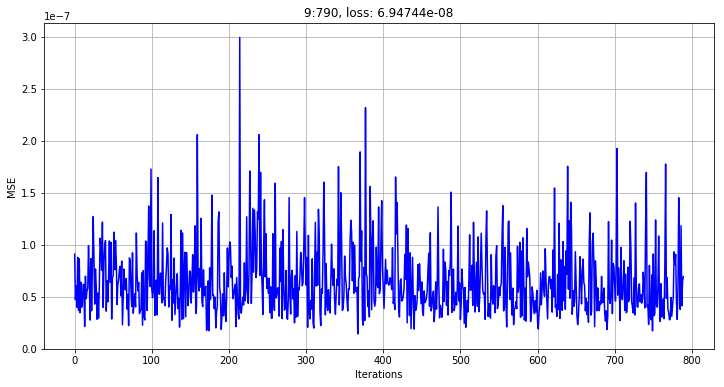

In [13]:
'''
Epoch based train loop
'''
#denom = 2*(2**(1/2.)) # 2 * sqrt(2)
#eps = 0.095
#bound = ((-1/denom) + eps, (1/denom) - eps)
fwd_type = 0 # [0: fwd_external, 1: fwd_diffs, 2: fwd_preds]
rs_start = RS_IDX[zX]
rs_target = RS_IDX[zY]
bound = (BOUND, 1-BOUND)
for cur_epoch in range(num_epochs):
    shuffled_idx = xp.random.choice(X_train.shape[1], X_train.shape[1])
    X_train = X_train[:,shuffled_idx]
    for cur_iter in range(X_train.shape[1]):
        model.zerograds() # must always zero grads before another forward pass!    
        # create mini-batches for training
        _x_in = X_train[:,cur_iter] # shape (11, 1, 4096, 6), retaining dim for convenience downstream
        _x_in = random_augmentation_shift(_x_in)[:,None,...] # expand dim lost
        x_in = chainer.Variable(_x_in)
        if model_type == 3:
            # fwd
            if fwd_type == 0: # external
                x_hat, loss = model.fwd_input(x_in)
            elif fwd_type == 1:
                x_hat, bounded_squared_error = model.fwd_input_pred_diff(x_in)
                loss = F.mean(F.sum(bounded_squared_error, axis=-1))
            else:
                #rs_start, rs_target = fwd_type
                x_hat = model.fwd_pred(x_in, rs_tup=(rs_start, rs_target))
                loss = nn.get_bounded_MSE(x_hat, x_in[rs_target], bound)
        elif model_type == 4:
            x_hat, loss = model.fwd_input_pred_diff(x_in)
            #loss = nn.get_bounded_MSE(x_hat, x_in[rs_target], bound)
            loss = F.mean(F.sum(F.squared_difference(x_hat[...,:3], x_in[rs_target, :, :, :3])))
        else:
            x_hat = model(x_in[rs_start], add=True)
            loss = nn.get_bounded_MSE(x_hat, x_in[rs_target], bound)

        # backprop and update
        loss.backward() # this calculates all the gradients (backprop)
        optimizer.update() # this updates the weights    
        train_loss_history[cur_epoch, cur_iter] = cuda.to_cpu(loss.data)
        if cur_iter % 10 == 0 and cur_iter != 0:
            y = train_loss_history[cur_epoch, :cur_iter]
            plt.close('all')
            title = '{}:{}, loss: {:.6}'.format(cur_epoch, cur_iter, y[-1])
            fig = data_utils.plot_training_curve(y, cur_iter, yclip=-1, title=title)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(0.0001)
    np.save(loss_path + save_label + 'train_loss', train_loss_history)
    #print('{}: converged at {}'.format(model_save_label, np.median(lh_train[-150:])))
    # save model, optimizer
np.save(loss_path + save_label + 'train_loss', train_loss_history)
data_utils.save_model([model, optimizer], model_dir + model_save_label)

In [16]:
x0, x2 = x_in[0], x_in[2]
x0_loc = x0[...,:3]
x2_loc = x2[...,:3]
bidx = nn.get_bounded(x2_loc, bound)

In [19]:
bhat = F.get_item(x0_loc, bidx)

(1, 4096, 3)

In [12]:
nn.get_bounded_squared_error(x_in[0], x_in[2], bound).shape

(1, 4096, 6)

In [14]:
avgs = [np.mean(train_loss_history[i]) for i in range(num_epochs)]

In [15]:
avgs

[9.2389143e-07, 3.2228485e-08, 2.6340038e-08, 2.4386509e-08]

In [16]:
model.channels

[6, 32, 128, 256, 32, 16, 6]

In [14]:
'''
Iteration based train loop
'''
#denom = 2*(2**(1/2.)) # 2 * sqrt(2)
#eps = 0.095
#bound = ((-1/denom) + eps, (1/denom) - eps)
"""
bound = (BOUND, 1-BOUND)
for cur_iter in range(num_iters):
    model.zerograds() # must always zero grads before another forward pass!
    
    # create mini-batches for training
    _x_in, _x_true = data_utils.next_minibatch([X_train, Y_train], mb_size, data_aug='shift')
    #_x_in, _x_true = data_utils.normalize(_x_in), data_utils.normalize(_x_true)    
    x_in, x_true = chainer.Variable(_x_in), chainer.Variable(_x_true)
    
    # get prediction and loss
    x_hat = model(x_in, add=True) # prediction
    loss = nn.get_bounded_MSE(x_hat, x_true, boundary=bound) # bound = 0.095                
    #loss, loc_loss, vel_loss = nn.get_bounded_MSE_vel(x_hat, x_true, boundary=BOUND) # bound = 0.095
    
    # backprop and update
    loss.backward() # this calculates all the gradients (backprop)
    optimizer.update() # this updates the weights
    
    train_loss_history[cur_iter] = cuda.to_cpu(loss.data)
    if cur_iter % 10 == 0 and cur_iter != 0:
        y = train_loss_history[:cur_iter]
        plt.close('all')
        fig = data_utils.plot_training_curve(y, cur_iter, yclip=-1)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)

np.save(loss_path + save_label + 'train_loss', train_loss_history)
#print('{}: converged at {}'.format(model_save_label, np.median(lh_train[-150:])))
# save model, optimizer
data_utils.save_model([model, optimizer], model_dir + model_save_label)
"""
dont_print_cell_comments = None

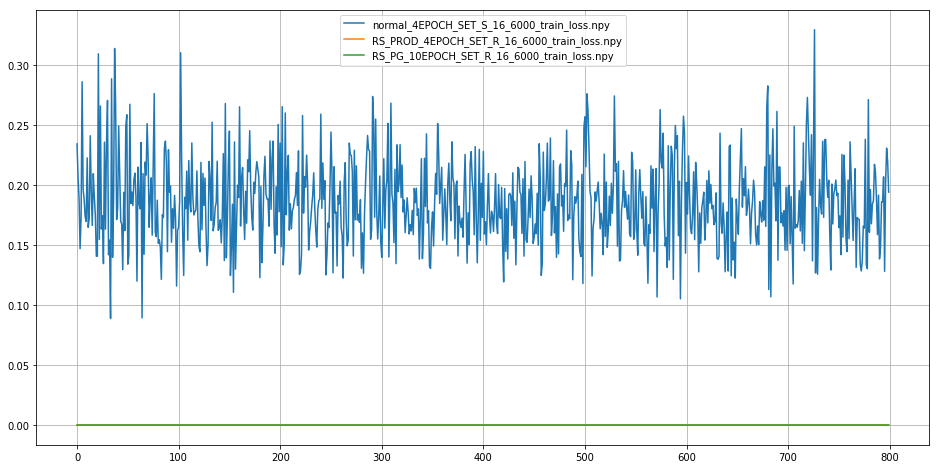

In [15]:
loss_labels = ['normal_4EPOCH_SET_S_16_6000_train_loss.npy',
               #'RS_extinputs_4EPOCH_SET_R_16_6000_train_loss.npy',
               #'RS_10EPOCH_SET_R_16_6000_train_loss.npy',
               #'RS2_MSE_10EPOCH_SET_R_16_6000_train_loss.npy',
               #'RS2_MSE_4EPOCH_SET_R_16_6000_train_loss.npy',
               'RS_PROD_4EPOCH_SET_R_16_6000_train_loss.npy',
               'RS_PG_10EPOCH_SET_R_16_6000_train_loss.npy',
              ]
lh_dict = {llabel:np.load(loss_path + llabel) for llabel in loss_labels}
plt.close('all')
plt.figure(figsize=(16,8))
plt.grid()
pstart = 200
for label, loss in lh_dict.items():
    plt.plot(loss[-1], label=label)
plt.legend()
display.display(plt.gcf())
display.clear_output(wait=True)

In [14]:
from chainer.serializers import load_npz
model = models.GraphModel(channels)
model_save_label = 'G_16_0400_77743196_'
load_npz('{}{}.model'.format(model_dir, model_save_label), model)
if use_gpu: model.to_gpu()

In [19]:
thetas = np.load('thetas_timesteps.npy').item()
theta = thetas[(num_particles, zX, zY)]['W']

In [17]:
# validation
#validation_loss_history = np.zeros((num_val_batches))
rs_start = RS_IDX[zX]
rs_target = RS_IDX[zY]
val_rs_tuple_pred = (rs_start, rs_target) # 0.6 -> 0.0
with chainer.using_config('train', False):
    for val_iter in range(X_val.shape[1]):
        _val_in   = X_val[rs_start,  val_iter:val_iter+1] # shape (1,4096,6)
        _val_true = X_val[rs_target, val_iter:val_iter+1] # shape (1,4096,6)
        val_in, val_true = chainer.Variable(_val_in), chainer.Variable(_val_true)
        if model_type == 3: val_hat  = model.fwd_pred(val_in, val_rs_tuple_pred)
        else: val_hat = model(val_in)
        #val_hat = val_in.data[...,:3] + theta*val_in.data[...,3:]
        #val_loss = nn.mean_squared_error(val_in, val_true)
        val_loss = nn.mean_squared_error(val_hat, val_true)
        
        validation_loss_history[val_iter] = cuda.to_cpu(val_loss.data)
        print('{:<3}: {:.8}'.format(val_iter, validation_loss_history[val_iter]))
    np.save(loss_path + save_label + 'val_loss', validation_loss_history)
    print('{}: validation avg {}'.format(model_save_label, np.mean(validation_loss_history)))

0  : 0.17818001
1  : 0.16011807
2  : 0.17569922
3  : 0.16268942
4  : 0.18417557
5  : 0.16670951
6  : 0.15758719
7  : 0.16962294
8  : 0.1638914
9  : 0.16217683
10 : 0.17110074
11 : 0.17300251
12 : 0.17085493
13 : 0.18259229
14 : 0.17727189
15 : 0.16528794
16 : 0.17426872
17 : 0.16213928
18 : 0.16375229
19 : 0.16946094
20 : 0.16925491
21 : 0.16861509
22 : 0.16815281
23 : 0.17678778
24 : 0.1495439
25 : 0.15951632
26 : 0.17348103
27 : 0.19231556
28 : 0.16721405
29 : 0.15841122
30 : 0.14316335
31 : 0.14303924
32 : 0.17267579
33 : 0.16814817
34 : 0.1675182
35 : 0.17273134
36 : 0.17103085
37 : 0.16264592
38 : 0.16656382
39 : 0.14017127
40 : 0.17438693
41 : 0.17099996
42 : 0.17175777
43 : 0.17322326
44 : 0.16550682
45 : 0.18371615
46 : 0.16405691
47 : 0.18486448
48 : 0.15401949
49 : 0.15905821
50 : 0.17788547
51 : 0.16971129
52 : 0.16787633
53 : 0.14395595
54 : 0.14924686
55 : 0.17577659
56 : 0.14497592
57 : 0.17896822
58 : 0.14405093
59 : 0.17585795
60 : 0.17531894
61 : 0.18849441
62 : 0.1642

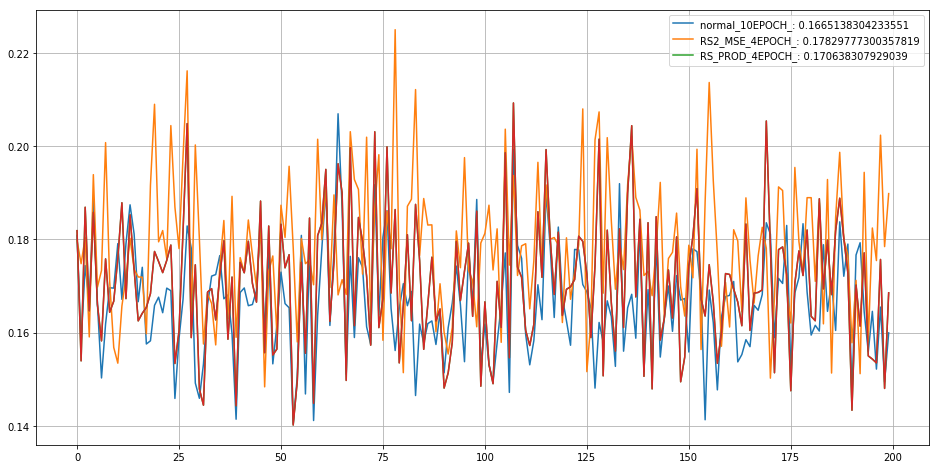

In [21]:
loss_labels = [#'RS_extinputs_4EPOCH_SET_R_16_6000_val_loss.npy',
               'normal_10EPOCH_SET_S_16_6000_val_loss.npy',
               #'RS_10EPOCH_SET_R_16_6000_val_loss.npy',
               #'RS2_4EPOCH_SET_R_16_6000_val_loss.npy',
               #'RS2_MSE_10EPOCH_SET_R_16_6000_val_loss.npy',
               'RS2_MSE_4EPOCH_SET_R_16_6000_val_loss.npy',
               'RS_PROD_4EPOCH_SET_R_16_6000_val_loss.npy',
              ]
lh_dict = {llabel:np.load(loss_path + llabel) for llabel in loss_labels}
plt.close('all')
plt.figure(figsize=(16,8))
plt.grid()
for label, loss in lh_dict.items():
    avg = np.mean(loss)
    label = '{}: {}'.format(label[:15], avg)
    plt.plot(loss, label=label)
plt.plot(validation_loss_history)
plt.legend()
display.display(plt.gcf())
display.clear_output(wait=True)

In [18]:
#rot2lh = validation_loss_history
xp.mean(xp.sum(xp.square(X_val[...,:3] - Y_val[...,:3]), axis=-1))

array(0.03137577, dtype=float32)

In [13]:


0  : 0.00071449857
1  : 0.00083440135
2  : 0.00069077744
3  : 0.00076021155
4  : 0.00066414644
5  : 0.00076436519
6  : 0.00068148802
7  : 0.00077487406
8  : 0.00075997895
9  : 0.00072597218
10 : 0.00074742711
11 : 0.0006032426
12 : 0.0007503003
13 : 0.0007320182
14 : 0.00079973473
15 : 0.00073265145
16 : 0.00074171007
17 : 0.00076671556
18 : 0.00073367765
19 : 0.00074930477
20 : 0.00067527685
21 : 0.00074823305
22 : 0.00077885698
23 : 0.00079977652
24 : 0.0007059208
Rot2GL_16_0400_77743196_: validation avg 0.0007374224159866572
    
0  : 0.00055363186
1  : 0.0006731872
2  : 0.00058509264
3  : 0.0006904325
4  : 0.00056985248
5  : 0.00058646151
6  : 0.00057804317
7  : 0.00069477817
8  : 0.00058836123
9  : 0.00064376084
10 : 0.00058327831
11 : 0.00052094873
12 : 0.00069097709
13 : 0.00060718646
14 : 0.00060357916
15 : 0.00063511333
16 : 0.00061753101
17 : 0.00061934261
18 : 0.00070599839
19 : 0.00063490745
20 : 0.00057715503
21 : 0.00058344653
22 : 0.00068214984
23 : 0.00060094299
24 : 0.00063226151
Rot2GL_16_0400_77743196_: validation avg 0.0006183368014171719
0  : 0.00063232199
1  : 0.00069677189
2  : 0.00065076264
3  : 0.00073845498
4  : 0.00058847119
5  : 0.0006447584
6  : 0.00062783115
7  : 0.00073686329
8  : 0.0006396636
9  : 0.00069760205
10 : 0.0006765736
11 : 0.00054225337
12 : 0.00072450895
13 : 0.00066313695
14 : 0.00069704035
15 : 0.0006880436
16 : 0.00071569113
17 : 0.00069740042
18 : 0.00073569786
19 : 0.00069740979
20 : 0.00064883736
21 : 0.000624654
22 : 0.00073985819
23 : 0.00062950642
24 : 0.00066471507
Rot3G_16_0400_77743196_: validation avg 0.0006719531305134297
    
0  : 9.3290488e-05
1  : 9.1763468e-05
2  : 8.4180276e-05
3  : 0.00013588619
4  : 8.1585691e-05
5  : 8.4469924e-05
6  : 8.4433683e-05
7  : 9.1588248e-05
8  : 6.9105059e-05
9  : 8.0118167e-05
10 : 8.2520099e-05
11 : 7.4855241e-05
12 : 0.00010116811
13 : 8.4584281e-05
14 : 0.00010005159
15 : 9.2386865e-05
16 : 9.5140014e-05
17 : 9.0737449e-05
18 : 0.00010576588
19 : 9.0127731e-05
20 : 8.2126113e-05
21 : 8.2276296e-05
22 : 9.8431243e-05
23 : 9.0143083e-05
24 : 8.8505287e-05
G_16_0400_77743196_: validation avg 9.020961908390746e-05

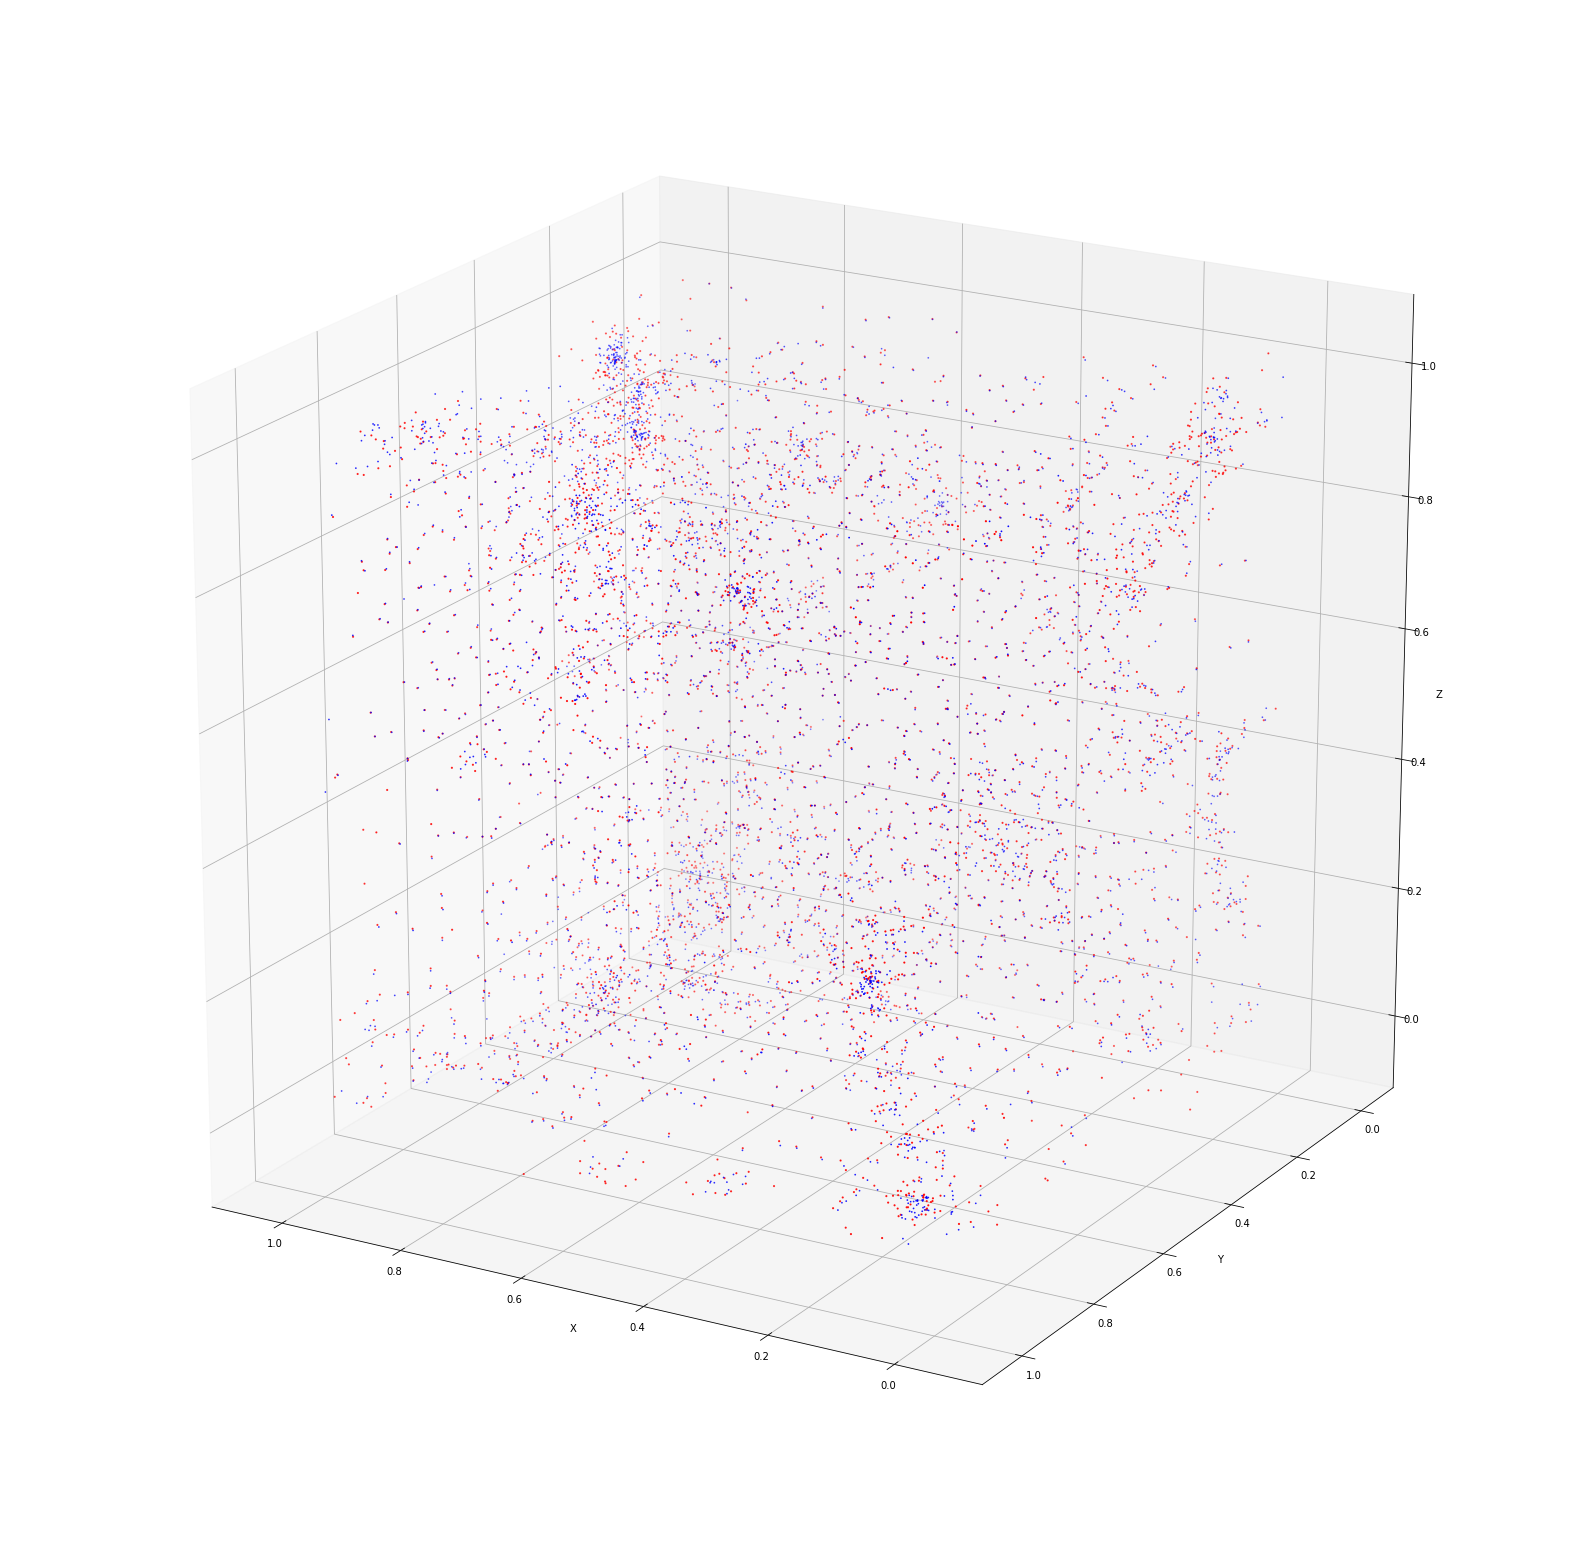

In [15]:
'''
plot point cloud
'''
from IPython import display
j = 3
fsize = (28,28)
particle_size = (.6, 1.3)
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = data_utils.plot_3D_pointcloud(xt, xh, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image